### Import Dependecies

In [ ]:
import os
import itertools
import numpy as np
import sympy as sp

import colorsys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.linear_model import LinearRegression

import dimod
from dimod import BinaryQuadraticModel, ExactSolver
from dwave.system import DWaveSampler, EmbeddingComposite

### Synthetic Data Generator

In [ ]:
def generate_linear_regression_problem(n, num_samples=5, weight_range=(-1, 1), feature_range=(-5, 5), 
                                       noise_std=0.0, random_seed=123):
    """
    Generate a linear regression problem with n weights and optional Gaussian noise.

    Parameters:
        n (int): Number of weights (features).
        num_samples (int): Number of data points to generate.
        weight_range (tuple): Range (min, max) for randomly generated weights.
        feature_range (tuple): Range (min, max) for randomly generated features.
        noise_std (float): Standard deviation of Gaussian noise added to y_values.
        random_seed (int): Seed for reproducibility.

    Returns:
        X (list): Feature matrix.
        y_values (list): Target values with noise.
        true_weights (list): The true weight values used to generate y_values.
    """
    np.random.seed(random_seed)  # For reproducibility

    # Generate random weights in the given range
    true_weights = np.random.uniform(weight_range[0], weight_range[1], size=(n, 1))

    # Generate random feature matrix X
    X = np.random.uniform(feature_range[0], feature_range[1], size=(num_samples, n))

    # Compute y_values using the linear transformation y = Xw
    y_values = np.matmul(X, true_weights).T[0]

    # Add Gaussian noise to y_values
    noise = np.random.normal(loc=0, scale=noise_std, size=y_values.shape)
    y_values_noisy = y_values + noise

    return X.tolist(), y_values_noisy.tolist(), true_weights.T[0].tolist()

# Example usage with noise added
X, y_values, true_weights = generate_linear_regression_problem(n=1, num_samples=30, noise_std=0.2)

print("Feature Matrix X:", X)
print("Target Values y (with noise):", y_values)
print("True Weights:", true_weights)


Feature Matrix X: [[-2.1386066504962056], [-2.731485464357969], [0.5131476908289123], [2.1946896978556305], [-0.7689353987553904], [4.807641983846155], [1.8482973858486327], [-0.19068098515639065], [-1.0788248180584947], [-1.5682198384913058], [2.2904970738404167], [-0.6142775532037561], [-4.403221033904316], [-1.0195574466956856], [2.379954057320357], [-3.175082695465], [-3.245482438525075], [0.3155137384183835], [0.3182758709686606], [1.344009585513211], [3.4943179407778953], [2.244553248606352], [1.1102351067758285], [2.2244338257022154], [-1.7704108614682177], [-1.3821134437768592], [-2.717367691210444], [-2.0628595361117066], [1.309761238544878], [-4.078950600549248]]
Target Values y (with noise): [-1.2114681070300555, -1.4291964100653771, -0.34840943474379094, 0.8155462847487085, -0.44134045829190016, 1.5342801984846082, 1.1985872165495866, -0.06792725887529509, -0.4928400047992461, -0.7612202074136379, 1.1079454235512873, -0.28971882968781804, -1.7527755722832223, -0.73276239929

### i-QLS Algorithm


**Note:** If you want to run on a real quantum annealer, this requires you to have an account in [D-Wave Ocean](https://cloud.dwavesys.com/), up on logging in, the D-Wave Leap dashboard is displayed, you can find the private token on the left column under **Solver API Token**, and place it in a file named `dwave-api-token.txt` in the same directory as this notebook.


If you do not wish to run the problem on the remote quantum annealer, you can also try out the D-Wave's exact solver which runs locally on your machine which is the default implementation below but does not scale well for larger number of features.

In [ ]:
def i_qls(number_of_features=2, bits_per_weight=2, number_of_iterations=1, initial_bound=1000, X=None, y_values=None):
    bit_count = number_of_features * bits_per_weight
    b = [sp.symbols(f'b{bit_idx}') for bit_idx in range(bit_count)]
    x = [sp.symbols(f'x{x_idx}') for x_idx in range(number_of_features)]

    upper_bound = 2 ** (bits_per_weight-1) - 2 ** -1
    upper_bound = initial_bound
    lower_bound = -upper_bound
    bin_sizes = [(upper_bound - lower_bound) / (2 ** bits_per_weight - 1) for _ in range(number_of_features)]
    w = [lower_bound + sum([bin_sizes[w_idx] * (2 ** (bits_per_weight - 1 - bit_idx)) * b[w_idx * bits_per_weight + bit_idx] 
                            for bit_idx in range(bits_per_weight)]) 
                            for w_idx in range(number_of_features)]

    # Initialize variables
    iteration_count = 0
    mse_list = []  # To store MSE for each iteration
    weights_dict = {}
    lower_bounds_dict = {}
    upper_bounds_dict = {}
    mse = np.mean([(y_val - sum([0 * x[w_idx] for w_idx in range(number_of_features)])) ** 2 for x, y_val in zip(X, y_values)])
    mse_list.append(mse)
    print(f"Iteration {iteration_count} - MSE: {mse}")
    lower_bounds_list = []
    upper_bounds_list = []
    weights_list = []
    for w_idx,weight in enumerate(w):
        weights_list.append(0)
        lower_bounds_list.append(lower_bound)
        upper_bounds_list.append(upper_bound)
    weights_dict[iteration_count] = weights_list
    lower_bounds_dict[iteration_count] = lower_bounds_list
    upper_bounds_dict[iteration_count] = upper_bounds_list
    reduction_factor = 2
    if bits_per_weight == 1:
        reduction_factor = 4

    while iteration_count < number_of_iterations:
        # Update weights in each iteration
        if iteration_count:
            w = []
            lower_bounds_list = []
            upper_bounds_list = []
            weights_list = []
            for w_idx, opt_weight in enumerate(optimal_weights):
                # Update bounds in each iteration
                upper_bound = opt_weight + (bin_sizes[w_idx] / reduction_factor)
                lower_bound = opt_weight - (bin_sizes[w_idx] / reduction_factor)
                weights_list.append(opt_weight)
                lower_bounds_list.append(lower_bound)
                upper_bounds_list.append(upper_bound)
                bin_sizes[w_idx] = (upper_bound - lower_bound) / (2 ** bits_per_weight - 1)
                w.append(lower_bound + sum([bin_sizes[w_idx] * (2 ** (bits_per_weight - 1 - bit_idx)) * b[w_idx * bits_per_weight + bit_idx] for bit_idx in range(bits_per_weight)]))
            weights_dict[iteration_count] = weights_list
            lower_bounds_dict[iteration_count] = lower_bounds_list
            upper_bounds_dict[iteration_count] = upper_bounds_list

        # Calculate the total loss (MSE)
        total_loss = sum([(y_val - sum([w[w_idx] * x[w_idx] for w_idx in range(number_of_features)])) ** 2 for i, (x, y_val) in enumerate(zip(X, y_values))])
        total_loss_expanded = sp.expand(total_loss)
        simplified_loss = total_loss_expanded.subs({b[bit_idx] ** 2: b[bit_idx] for bit_idx in range(bit_count)})

        # Collect QUBO terms
        qubo_terms = sp.collect(simplified_loss, b + [b_i * b_j for b_i, b_j in itertools.combinations(b, 2)], evaluate=False)

        quadratic = {}
        linear = {}
        for term, coeff in qubo_terms.items():
            if isinstance(term, sp.Symbol):  # Linear terms (b0, b1, ...)
                idx = b.index(term)
                linear[idx] = coeff
            elif isinstance(term, sp.Mul):  # Interaction terms (b0*b1, ...)
                vars_in_term = list(term.args)
                idx1 = b.index(vars_in_term[0])
                idx2 = b.index(vars_in_term[1])
                quadratic[(idx1, idx2)] = coeff

        #############################################################################################################
        # SELECT THE QUBO SOLVER
        #############################################################################################################
        # This is to run locally on your system using an Exact QUBO solver
        sampler = ExactSolver()
        #############################################################################################################
        # Comment the above line, and uncomment the below three lines for running on a remote quantum annealer hardware
        # private_token = open('dwave-api-token.txt','r').read()
        # dwave_sampler = DWaveSampler(token = private_token)
        # sampler = EmbeddingComposite(dwave_sampler)
        #############################################################################################################
        
        # Solve the QUBO problem
        bqm = BinaryQuadraticModel(linear, quadratic, 0.0, dimod.BINARY)
        response = sampler.sample(bqm)
        # Get optimal solution and update weights
        optimal_solution = list(map(int, response.first.sample.values()))
        optimal_weights = [w[w_idx].subs({b[bit_idx]: optimal_solution[bit_idx] for bit_idx in range(bit_count)}) for w_idx in range(number_of_features)]

        # Calculate MSE at this iteration and store it
        mse = np.mean([(y_val - sum([optimal_weights[w_idx] * x[w_idx] for w_idx in range(number_of_features)])) ** 2 for x, y_val in zip(X, y_values)])
        mse_list.append(mse)

        iteration_count += 1
        print(f"Iteration {iteration_count} - MSE: {mse}")

        if mse==0:
            lower_bounds_list = []
            upper_bounds_list = []
            weights_list = []
            for w_idx, opt_weight in enumerate(optimal_weights):
                upper_bound = opt_weight
                lower_bound = opt_weight
                weights_list.append(opt_weight)
                lower_bounds_list.append(lower_bound)
                upper_bounds_list.append(upper_bound)
            weights_dict[iteration_count] = weights_list
            lower_bounds_dict[iteration_count] = lower_bounds_list
            upper_bounds_dict[iteration_count] = upper_bounds_list
            break

    return mse_list, optimal_weights, weights_dict, lower_bounds_dict, upper_bounds_dict


### Generate Synthetic Data

Here we generate the synthetic data with two features

In [7]:
X, y_values, true_weights = generate_linear_regression_problem(n=2, num_samples=100, random_seed=124)

true_weights

[-0.7878701880905346, 0.490942969771226]

### Visualize Synthetic Data

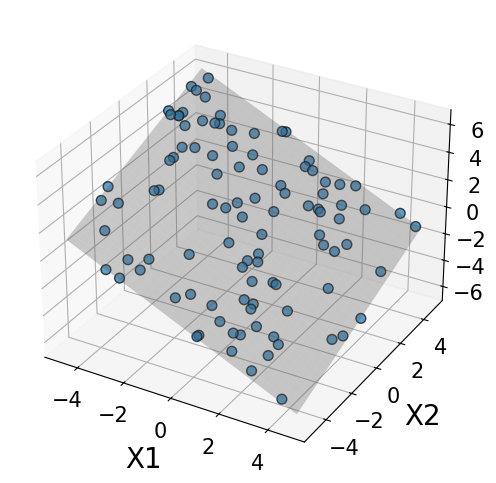

In [ ]:
# Ensure the folder exists
os.makedirs("linear_figures", exist_ok=True)

model = LinearRegression()
model.fit(X, y_values)
y_pred = model.predict(X)  # Predicted y values

# Convert to numpy array
X_np = np.array(X)

# If X has 2 features
if X_np.shape[1] == 2:
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of data points
    ax.scatter(X_np[:, 0], X_np[:, 1], y_values, c='#1f77b4', edgecolors='black', alpha=0.7, s=50)

    # Generate grid for the fitted plane
    x1_range = np.linspace(X_np[:, 0].min(), X_np[:, 0].max(), 30)
    x2_range = np.linspace(X_np[:, 1].min(), X_np[:, 1].max(), 30)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

    # Flatten the grid and make predictions
    X_grid = np.c_[X1_grid.ravel(), X2_grid.ravel()]
    y_pred_grid = model.predict(X_grid).reshape(X1_grid.shape)

    # Plot the fitted plane
    ax.plot_surface(X1_grid, X2_grid, y_pred_grid, color='grey', alpha=0.3, edgecolor='none')

    # Labels and title
    ax.set_xlabel("X1", fontsize=20, labelpad=10)
    ax.set_ylabel("X2", fontsize=20, labelpad=10)
    ax.set_zlabel("Target y", fontsize=20, labelpad=10)

    # Increase tick size for all axes
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='z', which='major', labelsize=15)
    
    # Save the plot
    plt.savefig("linear_figures/data_2d_with_plane.png", dpi=300, bbox_inches='tight', transparent=False)
    plt.show()


### Run i-QLS

Here we run the i-QLS algorithm varying the number of qubits used per weight from 1 to 6 coherent with the experiment to showcase the scalability presented in the paper.

In [ ]:
mse_dict = {}
weights = {}
lower_bounds = {}
upper_bounds = {}
for bpw in range(1,7):
    print("bits_per_weight", bpw)
    mse_list, optimal_weights, weights_dict, lower_bounds_dict, upper_bounds_dict = i_qls(
        number_of_features=len(X[0]), 
        bits_per_weight=bpw, 
        number_of_iterations=10, 
        initial_bound=1,
        X=X,
        y_values=y_values
    )
    mse_dict[bpw] = mse_list
    weights[bpw] = weights_dict
    lower_bounds[bpw] = lower_bounds_dict
    upper_bounds[bpw] = upper_bounds_dict


bits_per_weight 1
Iteration 0 - MSE: 7.7248744042895705
Iteration 1 - MSE: 2.99747666490657
Iteration 2 - MSE: 0.599234963115879
Iteration 3 - MSE: 0.570975531120023
Iteration 4 - MSE: 0.154879168654898
Iteration 5 - MSE: 0.0276215197825659
Iteration 6 - MSE: 0.00524788023671689
Iteration 7 - MSE: 0.000844746861988566
Iteration 8 - MSE: 0.0000284119540484663
Iteration 9 - MSE: 0.000137342965784456
Iteration 10 - MSE: 0.0000102160132080537
bits_per_weight 2
Iteration 0 - MSE: 7.7248744042895705
Iteration 1 - MSE: 0.475622333146205
Iteration 2 - MSE: 0.0828634855488540
Iteration 3 - MSE: 0.00181003375161479
Iteration 4 - MSE: 0.000130269689522483
Iteration 5 - MSE: 0.0000450399898206375
Iteration 6 - MSE: 0.00000176643930651694
Iteration 7 - MSE: 9.62154595737288E-7
Iteration 8 - MSE: 3.05041847878161E-7
Iteration 9 - MSE: 1.01631914764230E-8
Iteration 10 - MSE: 1.92151321911546E-9
bits_per_weight 3
Iteration 0 - MSE: 7.7248744042895705
Iteration 1 - MSE: 0.0869649664562548
Iteration 2 -

### Visualize Results

In [ ]:
# Function to lighten or darken a color
def adjust_color_shade(color, factor=0.7):
    """Modify the brightness of a color. factor<1 darkens, factor>1 lightens."""
    rgb = mcolors.to_rgb(color)  # Convert to RGB
    new_rgb = tuple(min(1, max(0, c * factor)) for c in rgb)  # Adjust brightness
    return mcolors.to_hex(new_rgb)  # Convert back to HEX



def adjust_color_hsl(color, h_shift=0.02, s_factor=3.5, l_factor=1.1):
    """
    Modify the HSL components of a color.
    - `h_shift`: Shift hue by a small amount (0.02 = 2% change)
    - `s_factor`: Multiply saturation (1 = no change, <1 = less saturated, >1 = more saturated)
    - `l_factor`: Multiply lightness (1 = no change, <1 = darker, >1 = lighter)
    """
    if color == '#8c564b':
        s_factor = 2
        l_factor=1.5
    rgb = mcolors.to_rgb(color)  # Convert HEX to RGB (0-1)
    h, l, s = colorsys.rgb_to_hls(*rgb)  # Convert RGB to HLS

    # Apply adjustments
    h = (h + h_shift) % 1  # Shift hue slightly
    s = max(0, min(1, s * s_factor))  # Adjust saturation
    l = max(0, min(1, l * l_factor))  # Adjust lightness

    new_rgb = colorsys.hls_to_rgb(h, l, s)  # Convert back to RGB
    return mcolors.to_hex(new_rgb)  # Convert RGB to HEX

Bits per Weight: 1
Bits per Weight: 2
Bits per Weight: 3
Bits per Weight: 4
Bits per Weight: 5
Bits per Weight: 6


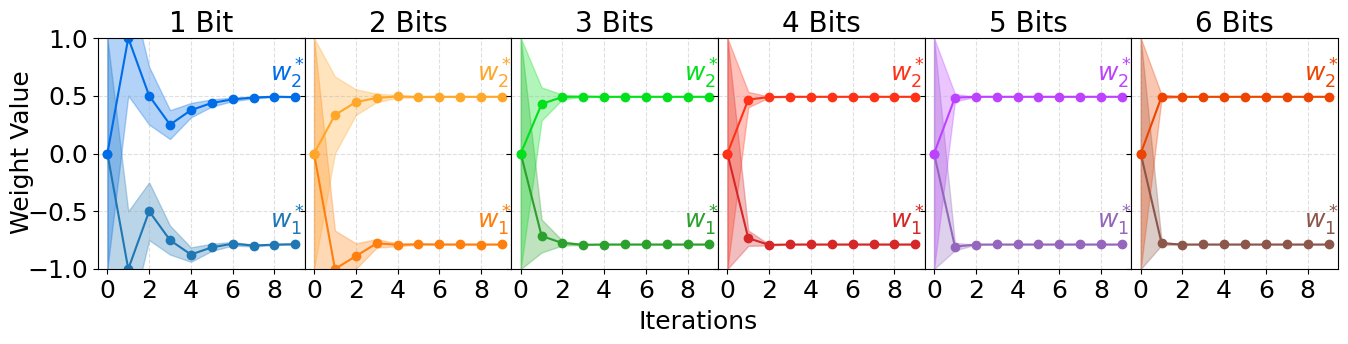

In [ ]:
# Define a set of visually distinct colors
colrs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# Number of subplots based on number of bit precisions
num_experiments = len(weights.keys())

# Create a single row of subplots with no gaps
fig, axes = plt.subplots(1, num_experiments, figsize=(16, 3), sharey=True, constrained_layout=False)

for ax, (colrs_idx, bpw) in zip(axes, enumerate(weights.keys())):
    print(f"Bits per Weight: {bpw}")

    # Extract iteration numbers
    iterations = list(weights[bpw].keys())

    for w_idx in range(len(weights[bpw][0])):
        # Extract weight, lower and upper bound values
        optimal_weights = [float(weights[bpw][i][w_idx]) for i in iterations]
        lower_vals = [float(lower_bounds[bpw][i][w_idx]) for i in iterations]
        upper_vals = [float(upper_bounds[bpw][i][w_idx]) for i in iterations]

        weight_color = colrs[colrs_idx] if w_idx == 0 else adjust_color_hsl(colrs[colrs_idx])

        ax.fill_between(iterations, lower_vals, upper_vals, color=weight_color, alpha=0.3)
        ax.plot(iterations, optimal_weights, marker='o', linestyle='-', color=weight_color)

        # Add text label at the last data point
        ax.text(iterations[-1] - 1.2, optimal_weights[-1]+0.2, 
                f'$w_{w_idx+1}^*$', fontsize=18, color=weight_color, 
                verticalalignment='center', horizontalalignment='left')

    # Formatting
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xticks(range(0, len(iterations), 2))
    ax.tick_params(axis='both', which='major', labelsize=18)
    if bpw>1:
        ax.set_title(f"{bpw} Bits", fontsize=20, pad=2)  # Smaller title with minimal spacing
    else:
        ax.set_title(f"{bpw} Bit", fontsize=20, pad=2)  # Smaller title with minimal spacing

    # Remove unnecessary subplot borders to reduce gaps
    for spine in ax.spines.values():
        spine.set_visible(True)

# Common x-axis and y-axis label
fig.text(0.5, -0.09, "Iterations", ha='center', fontsize=18)
fig.text(0.07, 0.5, "Weight Value", va='center', rotation='vertical', fontsize=18)

# Adjust layout for compactness (No space between subplots)
plt.subplots_adjust(wspace=0)  # Set horizontal space to zero

# Save and show
plt.savefig("linear_figures/data_2d_convergence_tight_v2.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()


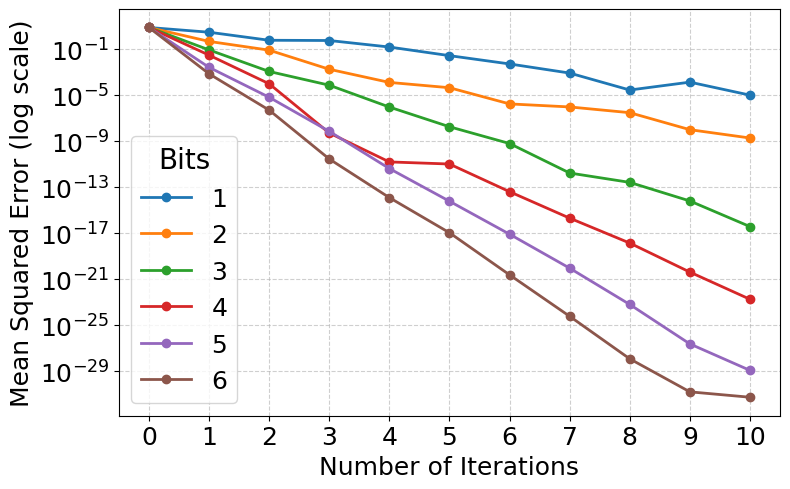

In [ ]:
# Define a set of visually distinct colors
colrs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# Create a figure with a larger size and better spacing
plt.figure(figsize=(8, 5))

# Plot with smoother lines and distinct markers
for idx, bpw in enumerate(range(1, 7)):
    plt.plot(range(len(mse_dict[bpw])), mse_dict[bpw], marker='o', linestyle='-', 
             linewidth=2, markersize=6, label=f'{bpw}', color=colrs[idx])

# Improve labels and title
plt.xlabel("Number of Iterations", fontsize=18)
plt.ylabel("Mean Squared Error (log scale)", fontsize=18)
plt.yscale('log')  # Log scale for better visualization of exponential decay
# plt.title("Convergence of MSE over Iterations", fontsize=14)

# Set tick size
plt.xticks(np.arange(len(mse_dict[bpw])))
plt.xticks(fontsize=18)  # Adjust x-axis tick font size
plt.yticks(fontsize=18)  # Adjust y-axis tick font size

# Add a grid with transparency
plt.grid(True, linestyle="--", alpha=0.6)

# Add legend with better formatting
plt.legend(title="Bits", fontsize=18, title_fontsize=20, loc="lower left")

# Improve layout spacing
plt.tight_layout()

plt.savefig("linear_figures/data_2d_MSE_vs_iters.png", dpi=300, bbox_inches='tight', transparent=False)
# Show the improved plot
plt.show()
